$$ Cloud-Architecture

># Importing Files

In [70]:

from vgg import FeatureExtractor
import numpy as np
from PIL import Image
import os
from pathlib import Path
import tkinter as tk 
from tkinter import filedialog 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()
from sklearn.cluster import KMeans


># Reading Files 

In [71]:
images = []
database = r"C:\Users\piyus\OneDrive\Documents\Office\21Sep\CBIR\vgg-git\sis\database"
for filename in os.listdir(database):
    img = Image.open(os.path.join(database,filename))
    '''Initializing dictionary '''
    image_info = {
        "image_name": os.path.basename(os.path.join(database,filename)),
        "image_data": img,
        "image_path": os.path.join(database,filename)
    }
    '''checking for image readability'''
    if img is not None:
        images.append(image_info)

In [72]:
print(images[0]["image_data"])### ignore this

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1254x837 at 0x27C05FFA190>


>#  Extracting features and saving it to numpy file

In [73]:
fe = FeatureExtractor()

# for img in images:
#     temp = fe.extract(img["image_data"])
#     feature_path = Path("C:/Users/piyus/OneDrive/Documents/Office/21Sep/CBIR/vgg-git/sis/features/") / (img["image_name"] + ".npy")
#     np.save(feature_path,temp)

># Taking reference image as input 

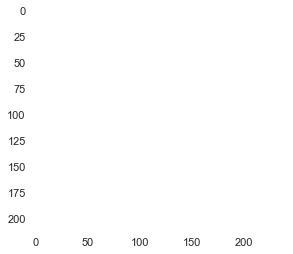

In [74]:
root = tk.Tk() 
root.withdraw() 
file_path = filedialog.askopenfilename() 
refer_image = Image.open(file_path)
# plt.imshow(img)
plt.imshow(refer_image)

>## Finding L2 Distance from query image

>reading from saved npy features 

In [75]:
# dists = np.linalg.norm(features-query, axis=1)
features = []
img_paths = []
folder = "C:/Users/piyus/OneDrive/Documents/Office/21Sep/CBIR/vgg-git/sis/features/"
# for feature_path in Path("./features").glob("*.npy"):
#     features.append(np.load(feature_path))
#     img_paths.append(Path("./database") / (feature_path.stem + ".jpg"))
for filename in os.listdir(folder):
    features.append(np.load(Path(folder) / filename))

features = np.array(features)

>## Appending Distance in final list

In [76]:
refer_fe = fe.extract(refer_image)
dists = np.linalg.norm(features-refer_fe, axis=1) 

In [77]:
i = 0
final = {"name" : [],
        "distance": []}
for a in dists:
    final["name"].append(images[i]["image_name"])
    final["distance"].append(a)
    i+=1
# for a in dists:
#     temp = {
#         "name" : images[i]["image_name"],
#         "distance" : a
#     }
#     final.append(temp)
#     i +=1

In [78]:
# print(final)

>## Scatter plot of distances

In [ ]:
plt.scatter(final["name"],final["distance"])

plt.show()

Converting Data into pandas dataframe 

In [79]:
 df = pd.DataFrame(final)
 x = df.iloc[:,1:3]

>## Initializing K means

In [80]:
kmeans = KMeans(
    init="random",
    n_clusters=100,
    n_init=10,
    max_iter=300,
    random_state=42
)

In [81]:
kmeans.fit(x)

KMeans(init='random', n_clusters=100, random_state=42)

In [82]:
print(x)

     distance
0    1.225922
1    1.095258
2    1.227573
3    1.000222
4    1.199311
..        ...
895  1.153000
896  1.088352
897  1.027572
898  1.160021
899  1.250577

[900 rows x 1 columns]


># Checking for cluster size

In [83]:
from scipy.cluster.vq import kmeans,vq

centroids,_ = kmeans(x,100)
# assign each sample to a cluster
idx,_ = vq(x,centroids)
#Print number of elements per cluster
print(np.bincount(idx))

[11  7  9  6 10  6  9  2 12  9  7  9  3 11 14 15 10 13 14  6  6 16  5 19
 10  4 20  5  3 19  5 17  6  6 20  7 15 19 10  3 11 13 12  8  8 17  4 11
 12  4  9  4  5  7  5  4 10 17 11  7  9  5  3  7 10 10 12 12  5  3 11  6
  4 11  5  5 12  4  9  8  9  5 13  4  6 12  8  4 10 17  5  5 20 11  6  6
  1 13  7 10]


In [84]:
k = 100
clusters = KMeans(k,random_state=42)
clusters.fit(x)

KMeans(n_clusters=100, random_state=42)

> #  Appending clusterid in new dataframe

In [85]:
y = pd.DataFrame(x,columns=["distance"])
y["clusterid"] = clusters.labels_

# `Printing new Dataframe`

In [86]:
y

,distance,clusterid
0,1.225922,48
1,1.095258,80
2,1.227573,22
3,1.000222,37
4,1.199311,38
...,...,...
895,1.153000,67
896,1.088352,82
897,1.027572,74
898,1.160021,68


| -------------------------------------------------------------------- | -------------------------------------------------------------------- |

# ``` Predicting new image's cluster id ```

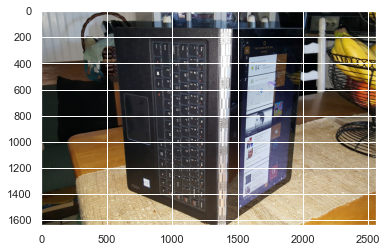

In [87]:
root = tk.Tk() 
root.withdraw() 
file_path = filedialog.askopenfilename() 
new_image = Image.open(file_path)
# plt.imshow(img)
plt.imshow(new_image)

>## Distance of new image from reference image

In [95]:
new_fe = fe.extract(new_image)
a = [new_fe]
dists_new = np.linalg.norm(a-refer_fe, axis=1) 


In [96]:
print(dists[0])

1.2550498


In [110]:
x.xs(0)["distance"] = float(dists_new[0])
x.head(1)

,distance
0,1.25505


In [111]:
# a = np.array([double([1.2])])
a = clusters.predict(x)
print(a[0])

88


In [116]:
y_new = y[y['clusterid']==a[0]]
y_new

,distance,clusterid
11,1.253481,88
120,1.254495,88
283,1.254582,88
306,1.253433,88
395,1.253158,88
526,1.253829,88
553,1.255050,88
694,1.255318,88
890,1.253433,88


In [141]:
y_new['d']=abs(y_new['distance']-dists_new[0])
y_new.index[y_new['d']==y_new['d'].min()][0]
    

C:\Users\piyus\AppData\Local\Temp/ipykernel_10896/54665641.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_new['d']=abs(y_new['distance']-dists_new[0])


553

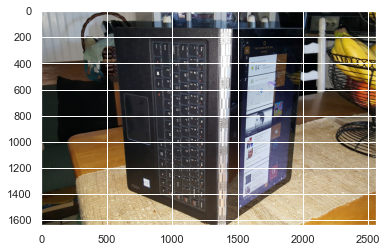

In [114]:
plt.imshow(images[553]['image_data'])